In [46]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [47]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [48]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [49]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [51]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     0.6368     0.2957     0.3379     0.6312     0.0000     0.0114   
2     0.5450     0.1034     0.3355     0.5415     0.0000     0.1447   
3     0.5090     0.1101     0.2838     0.5022     0.0000     0.0309   
4     0.4885     0.0970     0.3160     0.4811     0.0000     0.0000   
5     0.4556     0.0990     0.4344     0.4499     0.0000     0.0090   

   var7(t-1)  var1(t)  
1     0.7824   0.5450  
2     0.7827   0.5090  
3     0.7742   0.4885  
4     0.7788   0.4556  
5     0.7989   0.3226  


In [52]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25399, 1, 7) (25399,)


In [53]:
model = Sequential()
model.add(GRU(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 8760 samples, validate on 25399 samples
Epoch 1/20
8760/8760 [==============================] - 7s 823us/step - loss: 0.0167 - val_loss: 0.0110
Epoch 2/20
8760/8760 [==============================] - 3s 365us/step - loss: 0.0119 - val_loss: 0.0100
Epoch 3/20
8760/8760 [==============================] - 3s 371us/step - loss: 0.0112 - val_loss: 0.0095
Epoch 4/20
8760/8760 [==============================] - 3s 354us/step - loss: 0.0109 - val_loss: 0.0095
Epoch 5/20
8760/8760 [==============================] - 3s 367us/step - loss: 0.0108 - val_loss: 0.0094
Epoch 6/20
8760/8760 [==============================] - 3s 373us/step - loss: 0.0108 - val_loss: 0.0094
Epoch 7/20
8760/8760 [==============================] - 3s 391us/step - loss: 0.0107 - val_loss: 0.0093
Epoch 8/20
8760/8760 [==============================] - 3s 351us/step - loss: 0.0107 - val_loss: 0.0094
Epoch 9/20
8760/8760 [==============================] - 3s 359us/step - loss: 0.0107 - val_loss: 0.0093
Epoch 10/20
876

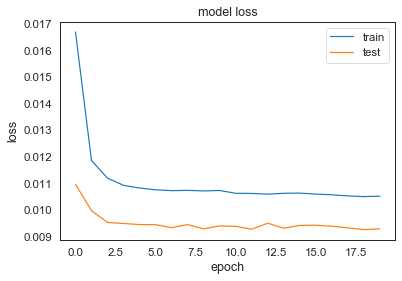

In [55]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [56]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.620


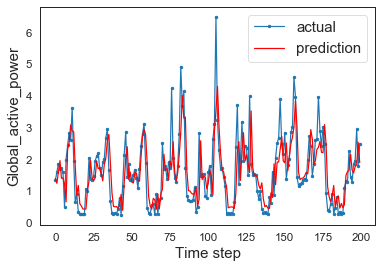

In [57]:
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

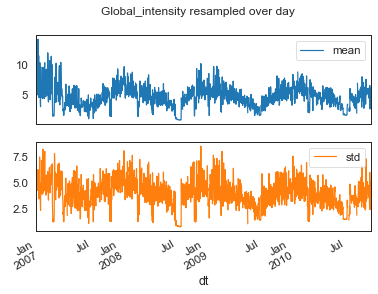

In [58]:
# Global intensesity - mean and std
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

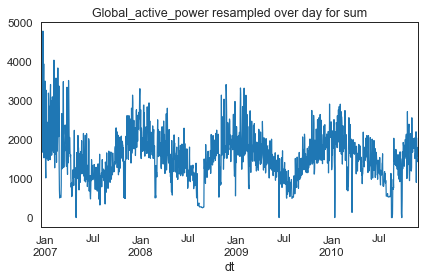

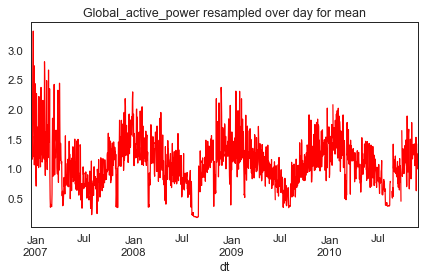

In [59]:
# Global acyive power - sum and mean
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

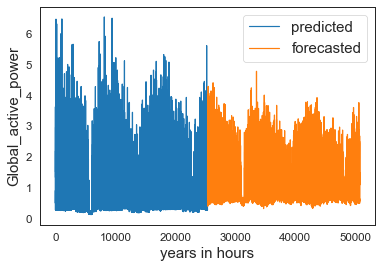

In [62]:
year = ['2007', '2008','2009','2010']
#aa=[x for x in range(len(years))]
plt.plot(inv_y)
plt.plot([None for i in inv_y] + [x for x in inv_yhat])
plt.ylabel('Global_active_power', size=15)
plt.xlabel('years in hours', size=15)
plt.legend(['predicted', 'forecasted'],fontsize=15)
plt.show()

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing


df=pd.read_csv('household_power_consumption.txt', delimiter=';')
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

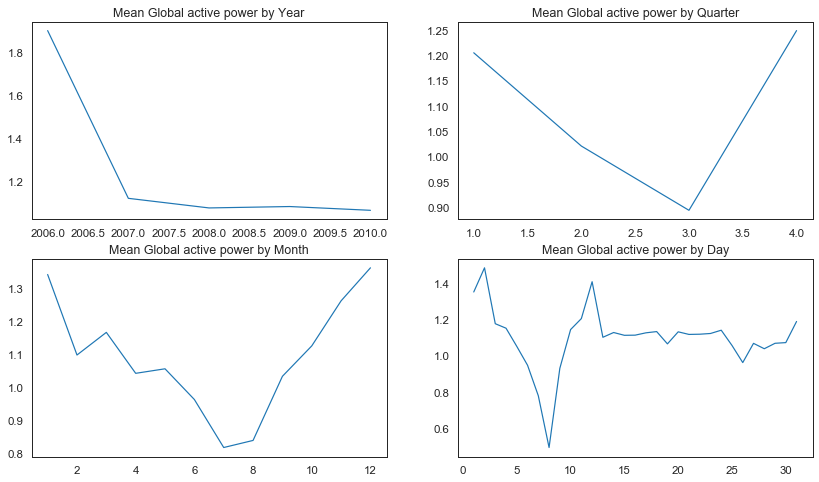

In [33]:

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
dataset.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
dataset.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
dataset.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
dataset.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');




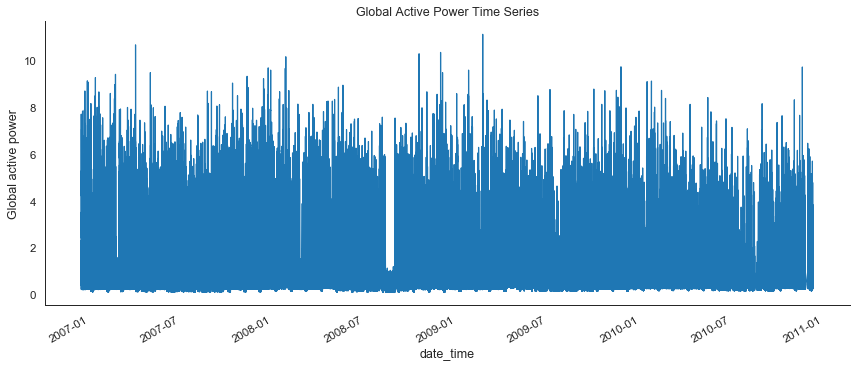

In [38]:
df1=dataset.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

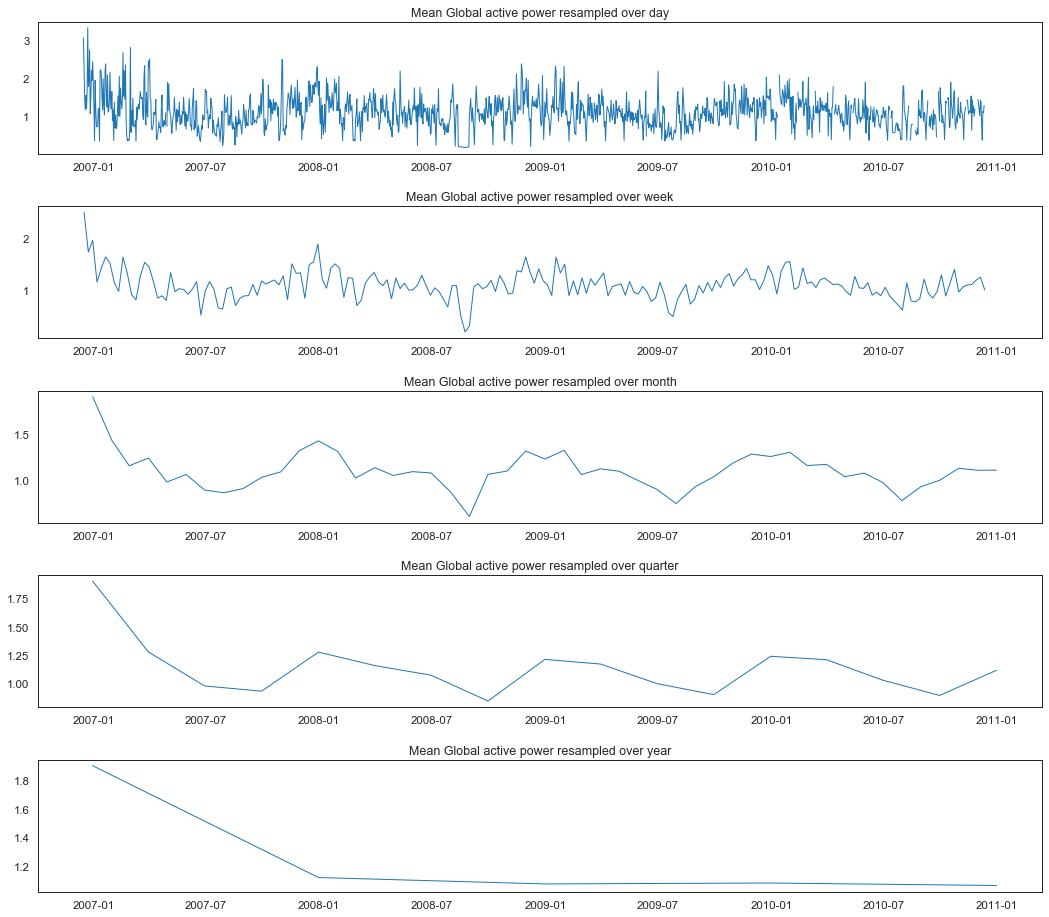

In [39]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');